In [3]:
import numpy as np
import keras
from glob import glob

import random

import shutil
import cv2
import matplotlib.pyplot as plt

# import tensorflow as tf

import scipy.spatial.distance as distance
from sklearn import metrics 

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

import torch.optim as optim


'''
from torch.autograd import Variable


import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import os
from PIL import ImageFile

'''




# random.seed(100)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'\nfrom torch.autograd import Variable\n\n\nimport torchvision\nfrom torchvision import datasets, models, transforms\nimport time\nimport copy\nimport os\nfrom PIL import ImageFile\n\n'

In [4]:
# TrainingSet and TestSet Preparation
# Extract info table from file
table_info = np.loadtxt('infotable.txt',delimiter=',',dtype=object)
num_total = table_info.shape[0]
print 'DataSet has '+str(num_total)+' images.'
num_class = table_info[num_total-1,3]
print 'DataSet contains '+num_class+' classes.'

# Generate TrainSet and TestSet: 80% 20%
# Genereate Training and Validition sets in TrainSet: 80% 20%

# Extract TrainSet and TestSet info tables from files
table_info_TrainSet_train = np.loadtxt('infotableTrainSet_train.txt',delimiter=',',dtype=object)
table_info_TrainSet_val = np.loadtxt('infotableTrainSet_val.txt',delimiter=',',dtype=object)

table_info_TestSet = np.loadtxt('infotableTestSet.txt',delimiter=',',dtype=object)

print 'TrainSet_train contains '+str(table_info_TrainSet_train.shape[0])+' images.'
print 'TrainSet_val contains '+str(table_info_TrainSet_val.shape[0])+' images.'
print 'TestSet contains '+str(table_info_TestSet.shape[0])+' images.'

# Extract pair info from file
list_TestSet_Pair = np.loadtxt('TestSetPairInfo.txt',delimiter=' ',dtype=int)
# print list_TestSet_Pair.shape[0]
# print list_TestSet_Pair.shape
# print list_TestSet_Pair[:,2]







DataSet has 13233 images.
DataSet contains 5749 classes.
TrainSet_train contains 8469 images.
TrainSet_val contains 2117 images.
TestSet contains 2647 images.


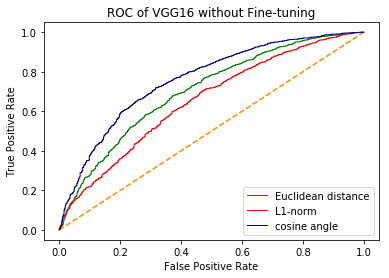

In [5]:
# VGG16 without fine-tuning
# Read in VGG16 model
Pretrain_vgg16 = models.vgg16(pretrained=True)

#print Pretrain_vgg16

new_classifier = nn.Sequential(*list(Pretrain_vgg16.classifier.children())[:-1])
Pretrain_vgg16.classifier = new_classifier
# Into evaluation mode. Otherwise, dropout layer still masks random outputs and the accuracy might be lower.
Pretrain_vgg16.eval()
#print Pretrain_vgg16

Img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                   ])



'''
# Distance info table
Vgg16_dis = np.zeros((list_TestSet_Pair.shape[0],3))

# Calculate distance in pair, and save into Vgg16_dis as Euclidean distance, L1-norm, cosine angle
for i in range(0,list_TestSet_Pair.shape[0]):#1):#
    P1_v  = list_TestSet_Pair[i,0]
    P2_v  = list_TestSet_Pair[i,1]
    
    #print table_info_TestSet[P1,2]
    #print table_info_TestSet[P2,2]
    
    IP1_v = cv2.imread(table_info_TestSet[P1_v ,2])
    IP2_v  = cv2.imread(table_info_TestSet[P2_v ,2])
    IP1_v  = Img_transform(IP1_v ) 
    IP2_v  = Img_transform(IP2_v )
    
    IP1_v  = IP1_v .view(1,3,250,250)
    IP2_v  = IP2_v .view(1,3,250,250)
    out_IP1_v  = Pretrain_vgg16(IP1_v )
    out_IP2_v  = Pretrain_vgg16(IP2_v )

    # print (out_IP1-out_IP2).data.numpy()
    
    dis_dif = (out_IP1_v -out_IP2_v ).data.numpy()
    # print dis_dif
    
    Vgg16_dis[i,0] = np.linalg.norm(dis_dif)
    Vgg16_dis[i,1] = np.linalg.norm(dis_dif,ord=1)
    Vgg16_dis[i,2] = distance.cosine(out_IP1_v .data.numpy(),out_IP2_v.data .numpy())
    
    if i%265==0:
        print 'Distance calculation is '+ str(i*100/(list_TestSet_Pair.shape[0]))+'% done'
    if i==list_TestSet_Pair.shape[0]-1:
        print 'Distance calculation is 100% done'
    #print  Alex_dis[i,:]
# Save distance info to file
np.savetxt('Vgg16DisInfo.txt', Vgg16_dis, fmt='%f',delimiter=' ')


'''
# Extract pair info from file
Vgg16_dis = np.loadtxt('Vgg16DisInfo.txt',delimiter=' ',dtype=float)


# Plot ROC curve
vgg_label = list_TestSet_Pair[:,2]
vgg_score_ed = Vgg16_dis[:,0]
vgg_score_l1 = Vgg16_dis[:,1]
vgg_score_ca = Vgg16_dis[:,2]

fpr_vgg_ed, tpr_vgg_ed, thresholds_vgg_ed = metrics.roc_curve(vgg_label, vgg_score_ed, pos_label=0)
# print fpr_alex_ed.shape

fpr_vgg_l1, tpr_vgg_l1, thresholds_vgg_l1 = metrics.roc_curve(vgg_label, vgg_score_l1, pos_label=0)
fpr_vgg_ca, tpr_vgg_ca, thresholds_vgg_ca = metrics.roc_curve(vgg_label, vgg_score_ca, pos_label=0)


plt.figure(1)
lw = 1
plt.plot([0,1], [0,1], color='darkorange',linestyle='dashed')
plt.plot(fpr_vgg_ed, tpr_vgg_ed, lw=lw, color='green',label='Euclidean distance')# (thresholds = %0.2f)' % thresholds_vgg_ed)
plt.plot(fpr_vgg_l1, tpr_vgg_l1, lw=lw, color='red',label='L1-norm ')# (thresholds = %0.2f)' % thresholds_vgg_l1)
plt.plot(fpr_vgg_ca, tpr_vgg_ca, lw=lw, color='navy',label='cosine angle')#  (thresholds = %0.2f)' % thresholds_vgg_ca)
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of VGG16 without Fine-tuning')
plt.legend(loc=4)
plt.show()





In [ ]:
# Vgg16 with fine-tuning
# Read in Vgg16 model
Pretrain_vgg16_ft = models.vgg16(pretrained=True)

#print Pretrain_vgg16
Pretrain_vgg16_ft.classifier  = nn.Sequential(nn.Dropout(),
                                                nn.Linear(25088, 4096),
                                                nn.ReLU(inplace=True),
                                                nn.Dropout(),
                                                nn.Linear(4096, 4096),
                                                nn.ReLU(inplace=True),
                                                nn.Linear(4096, int(num_class)),
                                               )

#print Pretrain_vgg16_ft

# Fine-tuning
Pretrain_vgg16_ft.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Pretrain_vgg16_ft.classifier.parameters(), lr=0.0001)

data_loss_vgg16_ft = np.zeros((1,1))

for epoch in range(2):#0):  # loop over the dataset multiple times

    running_loss = 0.0
    list_Train_ft_vgg = np.array(random.sample(range(0,table_info_TrainSet_train.shape[0]),1000))
    #print list_Train_ft[0:10]
    
    for j in range(0,1000):#00): #201):#
        
        i = list_Train_ft_vgg[j]
        #print i
        # get the inputs    
        inputs_vgg = cv2.imread(table_info_TrainSet_train[i,2])
        inputs_vgg = Img_transform(inputs_vgg) 
        inputs_vgg = inputs_vgg.view(1,3,250,250)        
        labels_vgg = torch.empty(1, dtype=torch.long).copy_(torch.tensor(int(table_info_TrainSet_train[i,4])-1))
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_vgg = Pretrain_vgg16_ft(inputs_vgg)
             
        loss = criterion(outputs_vgg, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #print running_loss
        
        if j % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, j + 1, running_loss / 200))
            data_loss_vgg16_ft = np.append(data_loss_vgg16_ft,[[float(running_loss / 200)]],axis=0)
            running_loss = 0.0
        '''
        if i == table_info_TrainSet_train.shape[0]: #200: #
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
        '''
        
        
print('Finished Training')

#print data_loss_vgg16_ft


8.67139720917
17.2541971207
25.3223772049
32.884376049
40.0810933113
45.4950962067
50.1429224014
53.8086576462
54.2644158304
54.3283598199
54.3373160604
54.3373162554
54.3374815663
54.3374815784
54.3374815838
54.3374815891
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895
54.3374815895


In [2]:
print data_loss_vgg16_ft

NameError: name 'data_loss_vgg16_ft' is not defined

In [ ]:

# Distance info table
Vgg16_dis_ft = np.zeros((list_TestSet_Pair.shape[0],3))

# Calculate distance in pair, and save into Vgg16_dis as Euclidean distance, L1-norm, cosine angle
for i in range(0,list_TestSet_Pair.shape[0]):#1):#
    P1_v  = list_TestSet_Pair[i,0]
    P2_v  = list_TestSet_Pair[i,1]
    
    #print table_info_TestSet[P1,2]
    #print table_info_TestSet[P2,2]
    
    IP1_v = cv2.imread(table_info_TestSet[P1_v ,2])
    IP2_v  = cv2.imread(table_info_TestSet[P2_v ,2])
    IP1_v  = Img_transform(IP1_v ) 
    IP2_v  = Img_transform(IP2_v )
    
    IP1_v  = IP1_v .view(1,3,250,250)
    IP2_v  = IP2_v .view(1,3,250,250)
    out_IP1_v  = Pretrain_vgg16(IP1_v )
    out_IP2_v  = Pretrain_vgg16(IP2_v )

    # print (out_IP1-out_IP2).data.numpy()
    
    dis_dif = (out_IP1_v -out_IP2_v ).data.numpy()
    # print dis_dif
    
    Vgg16_dis_ft[i,0] = np.linalg.norm(dis_dif)
    Vgg16_dis_ft[i,1] = np.linalg.norm(dis_dif,ord=1)
    Vgg16_dis_ft[i,2] = distance.cosine(out_IP1_v .data.numpy(),out_IP2_v.data .numpy())
    
    if i%265==0:
        print 'Distance calculation is '+ str(i*100/(list_TestSet_Pair.shape[0]))+'% done'
    if i==list_TestSet_Pair.shape[0]-1:
        print 'Distance calculation is 100% done'
    #print  Alex_dis[i,:]
# Save distance info to file
np.savetxt('Vgg16DisInfo_ft.txt', Vgg16_dis_ft, fmt='%f',delimiter=' ')


'''
# Extract pair info from file
Vgg16_dis_ft = np.loadtxt('Vgg16DisInfo_ft.txt',delimiter=' ',dtype=float)

'''
# Plot ROC curve
vgg_label = list_TestSet_Pair[:,2]
vgg_score_ed_ft = Vgg16_dis_ft[:,0]
vgg_score_l1_ft = Vgg16_dis_ft[:,1]
vgg_score_ca_ft = Vgg16_dis_ft[:,2]

fpr_vgg_ed_ft, tpr_vgg_ed_ft, thresholds_vgg_ed_ft = metrics.roc_curve(vgg_label, vgg_score_ed_ft, pos_label=0)
# print fpr_alex_ed.shape

fpr_vgg_l1_ft, tpr_vgg_l1_ft, thresholds_vgg_l1_ft = metrics.roc_curve(vgg_label, vgg_score_l1_ft, pos_label=0)
fpr_vgg_ca_ft, tpr_vgg_ca_ft, thresholds_vgg_ca_ft = metrics.roc_curve(vgg_label, vgg_score_ca_ft, pos_label=0)


plt.figure(1)
lw = 1
plt.plot([0,1], [0,1], color='darkorange',linestyle='dashed')
plt.plot(fpr_vgg_ed_ft, tpr_vgg_ed_ft, lw=lw, color='green',label='Euclidean distance')# (thresholds = %0.2f)' % thresholds_vgg_ed)
plt.plot(fpr_vgg_l1_ft, tpr_vgg_l1_ft, lw=lw, color='red',label='L1-norm ')# (thresholds = %0.2f)' % thresholds_vgg_l1)
plt.plot(fpr_vgg_ca_ft, tpr_vgg_ca_ft, lw=lw, color='navy',label='cosine angle')#  (thresholds = %0.2f)' % thresholds_vgg_ca)
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of VGG16 with Fine-tuning')
plt.legend(loc=4)
plt.show()

